This notebook demonstrates how to use `pretrained-microscopy-models` to perform segmentation on ni-based superalloys. This is the Super-1 dataset in the accompanying paper.

In [1]:
import os
import torch
import cv2
import random
import imageio

import numpy as np
import matplotlib.pyplot as plt
import pretrained_microscopy_models as pmm
import segmentation_models_pytorch as smp
import albumentations as albu

from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
# set random seeds for repeatability
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

## ML Model

In [4]:
# model parameters
architecture = 'UnetPlusPlus'
encoder = 'resnet50'
pretrained_weights = 'micronet'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the Unet model with a resnet backbone that is pre-trained on micronet
model = pmm.segmentation_training.create_segmentation_model(
    architecture=architecture,
    encoder = encoder,
    encoder_weights=pretrained_weights, # use encoder pre-trained on micronet
    classes=3 # secondary precipitates, tertiary precipitates, matrix
    )

## Dataset

In [3]:
DATA_DIR = 'Super1/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_annot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_annot')

#### Image Augmentation
Adding noise, contrast, random crops, flipping and other image augmentations can artifically augment the training dataset and make the model more robust to changes in these conditions

In [5]:
def get_training_augmentation():
    train_transform = [
        albu.Flip(p=0.75),
        albu.RandomRotate90(p=1),       
        albu.GaussNoise(p=0.5),
        
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1, limit=0.25),
                albu.RandomGamma(p=1),
            ],
            p=0.50,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                #albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.50,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1, limit=0.3),
                albu.HueSaturationValue(p=1),
            ],
            p=0.50,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    # This is turned off for this dataset
    test_transform = [
        #albu.Resize(height,width)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Create datasets

In [6]:
# how the images will be normalized. Use imagenet statistics even on micronet pre-training
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet') 

# pixel values of the annotations for each mask.
class_values = {'matrix': [0,0,0],
               'secondary': [255,0,0],
               'tertiary' : [0,0,255]}

training_dataset = pmm.io.Dataset(
    images=x_train_dir,
    masks=y_train_dir,
    class_values=class_values,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

validation_dataset = pmm.io.Dataset(
    images=x_valid_dir,
    masks=y_valid_dir,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataset = pmm.io.Dataset(
    images=x_test_dir,
    masks=y_test_dir,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

### Visualize datasets

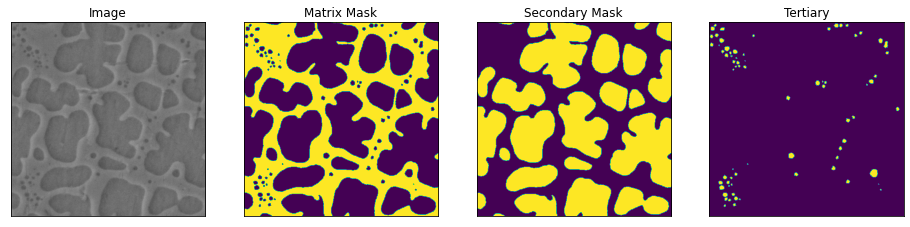

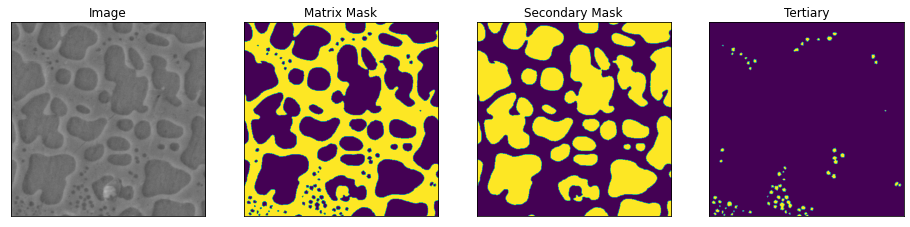

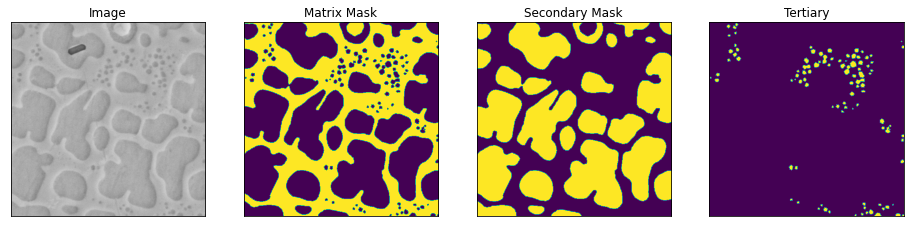

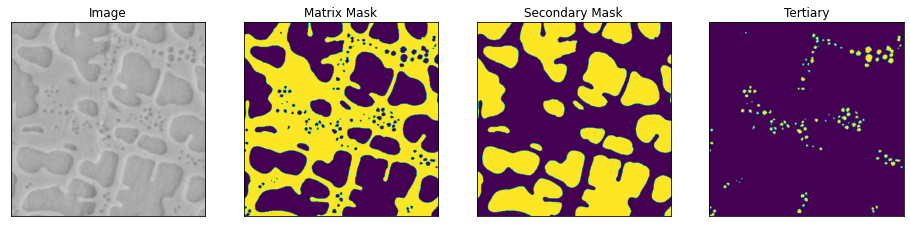

In [7]:
# validation data

visualize_dataset = pmm.io.Dataset(
    images=x_valid_dir,
    masks=y_valid_dir,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocessing_fn)
)

for im, mask in visualize_dataset:
    pmm.util.visualize(
        image=im,
        matrix_mask=mask[...,0].squeeze(),
        secondary_mask=mask[...,1].squeeze(),
        tertiary=mask[...,2].squeeze(),
    )

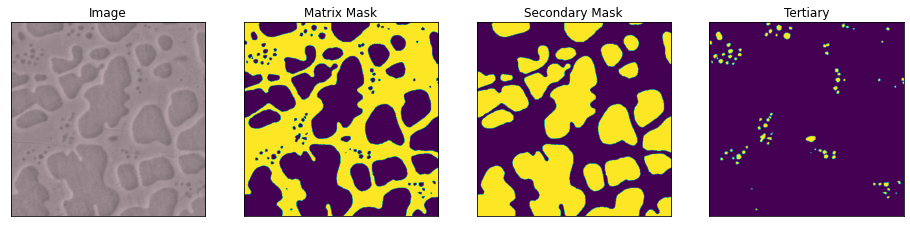

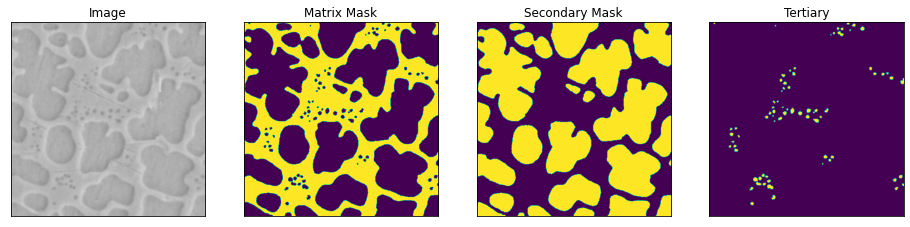

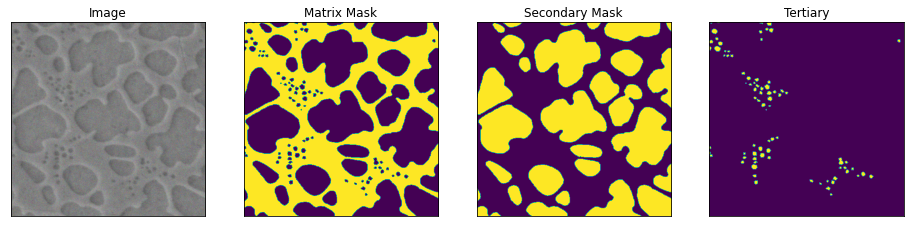

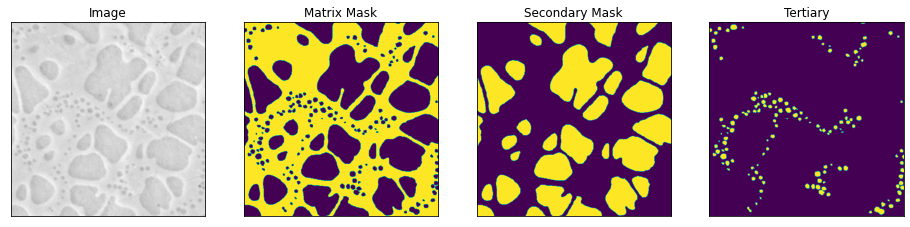

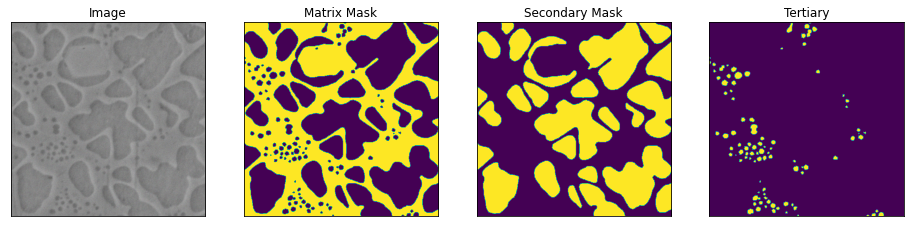

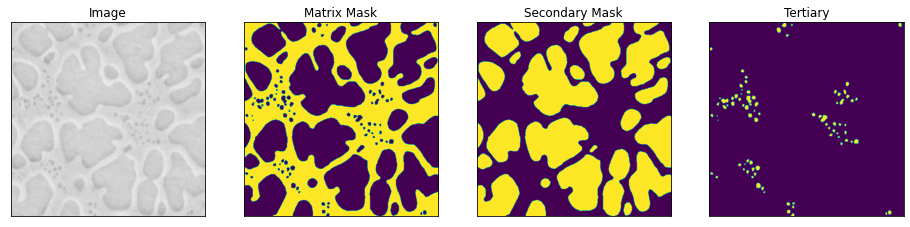

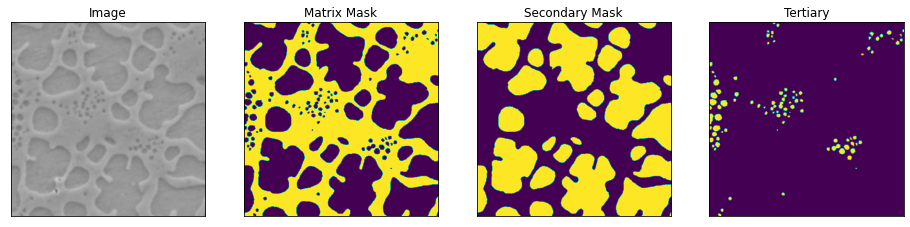

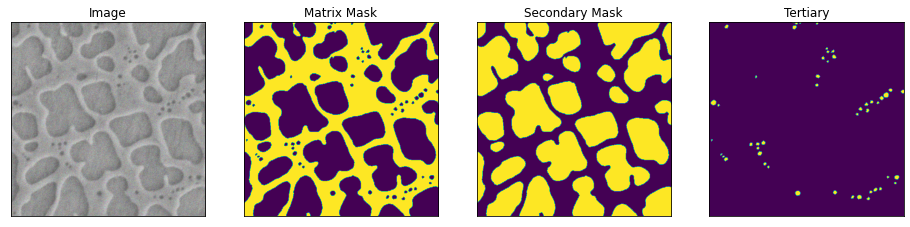

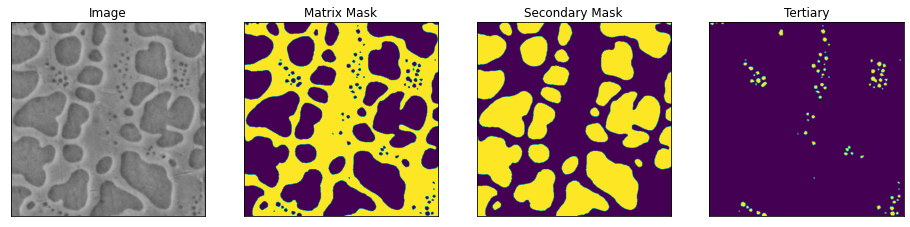

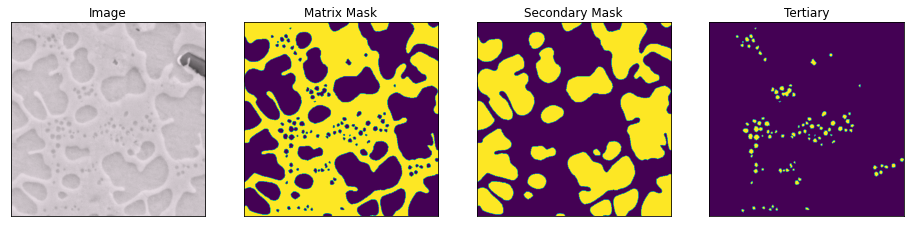

In [8]:
# augmented training data

augmented_dataset = pmm.io.Dataset(
    images=x_train_dir,
    masks=y_train_dir,
    class_values=class_values,
    augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocessing_fn)
)

for im, mask in augmented_dataset:
    pmm.util.visualize(
        image=im,
        matrix_mask=mask[...,0].squeeze(),
        secondary_mask=mask[...,1].squeeze(),
        tertiary=mask[...,2].squeeze(),
    )

## Train ML Model

In [9]:
state = pmm.segmentation_training.train_segmentation_model(
    model=model,
    architecture=architecture,
    encoder=encoder,
    train_dataset=training_dataset,
    validation_dataset=validation_dataset,
    class_values=class_values,
    patience=30,
    lr=2e-4,
    batch_size=6,
    val_batch_size=6,
    save_folder='models',
    save_name='UnetPlusPlus_resnet50_high_lr.pth.tar'
)


Epoch: 0, lr: 0.00020000, time: 0.00 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, DiceBCELoss - 0.688, iou_score - 0.2222]
Best model saved!

Epoch: 1, lr: 0.00020000, time: 12.31 seconds, patience step: 0, best iou: 0.2222
valid: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, DiceBCELoss - 0.6954, iou_score - 0.2168]

Epoch: 2, lr: 0.00020000, time: 4.86 seconds, patience step: 1, best iou: 0.2222
valid: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, DiceBCELoss - 0.6748, iou_score - 0.3656]
Best model saved!

Epoch: 3, lr: 0.00020000, time: 6.46 seconds, patience step: 0, best iou: 0.3656
valid: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, DiceBCELoss - 0.6696, iou_score - 0.3463]

Epoch: 4, lr: 0.00020000, time: 4.93 seconds, patience step: 1, best iou: 0.3656
valid: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, DiceBCELoss - 0.6667, iou_score - 0.3417]

Epoch: 5, lr: 0.00020000, time: 4.85 seconds, patience step: 2, best iou: 0.36

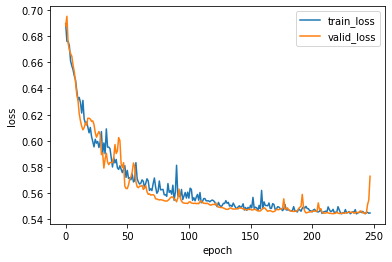

In [10]:
plt.plot(state['train_loss'], label='train_loss')
plt.plot(state['valid_loss'], label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
# drop the learning rate and keep training to see if we can squeeze a little more out.
model_path = Path('models', 'UnetPlusPlus_resnet50_high_lr.pth.tar')
state = pmm.segmentation_training.train_segmentation_model(
    model=str(model_path),
    architecture=architecture,
    encoder=encoder,
    patience=30,
    lr=1e-5,
    batch_size=6,
    val_batch_size=6,
    train_dataset=training_dataset,
    validation_dataset=validation_dataset,
    class_values=class_values,
    save_folder='models',
    save_name='UnetPlusPlus_resnet50_low_lr.pth.tar'
)


Epoch: 0, lr: 0.00001000, time: 0.00 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s, DiceBCELoss - 0.5441, iou_score - 0.9507]
Best model saved!

Epoch: 1, lr: 0.00001000, time: 12.79 seconds, patience step: 0, best iou: 0.9507
valid: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s, DiceBCELoss - 0.5443, iou_score - 0.9499]

Epoch: 2, lr: 0.00001000, time: 4.92 seconds, patience step: 1, best iou: 0.9507
valid: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s, DiceBCELoss - 0.5443, iou_score - 0.9493]

Epoch: 3, lr: 0.00001000, time: 4.43 seconds, patience step: 2, best iou: 0.9507
valid: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, DiceBCELoss - 0.5442, iou_score - 0.95]

Epoch: 4, lr: 0.00001000, time: 4.70 seconds, patience step: 3, best iou: 0.9507
valid: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, DiceBCELoss - 0.5441, iou_score - 0.9506]

Epoch: 5, lr: 0.00001000, time: 4.81 seconds, patience step: 4, best iou: 0.9507
valid: 100%|████

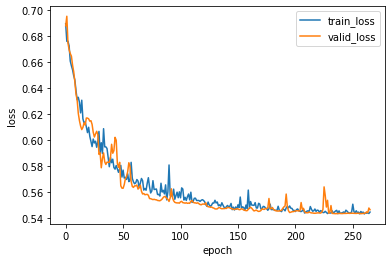

In [11]:
plt.plot(state['train_loss'], label='train_loss')
plt.plot(state['valid_loss'], label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluate Performance

In [32]:
# load best model
best_model_path = Path('models', 'UnetPlusPlus_resnet50_low_lr.pth.tar')
state = torch.load(best_model_path) 
best_model = pmm.segmentation_training.create_segmentation_model(
    architecture=architecture,
    encoder = encoder,
    encoder_weights=pretrained_weights, # use encoder pre-trained on micronet
    classes=3 # secondary precipitates, tertiary precipitates, matrix
    )
best_model.load_state_dict(pmm.util.remove_module_from_state_dict(state['state_dict']))

<All keys matched successfully>

In [33]:
# create test dataset
test_dataset = pmm.io.Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_values=class_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset without transformations for image visualization
test_dataset_vis = pmm.io.Dataset(
    x_test_dir, y_test_dir, 
    class_values=class_values,
)

In [34]:
# evaluate model on test set
loss = pmm.losses.DiceBCELoss(weight=0.7)
metrics = [smp.utils.metrics.IoU(threshold=0.5),]
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device='cuda',
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s, DiceBCELoss - 0.5454, iou_score - 0.942] 


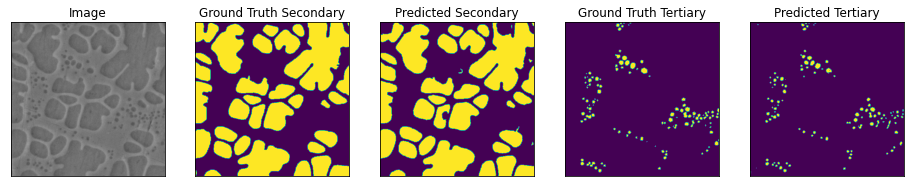

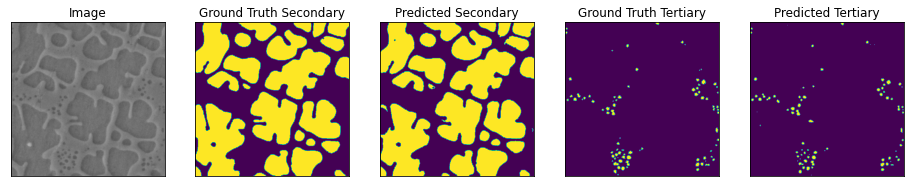

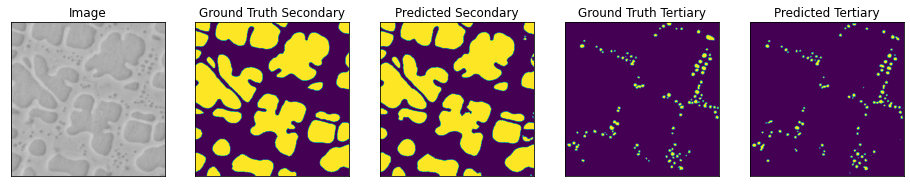

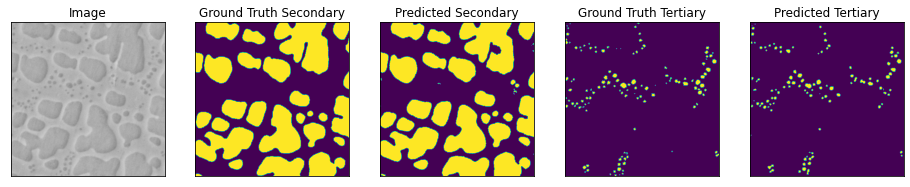

In [35]:
for n in range(len(test_dataset)):
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask_background = gt_mask[0].squeeze()
    gt_mask_second = gt_mask[1].squeeze()
    gt_mask_tert = gt_mask[2].squeeze()

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)


    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask_second = pr_mask[1].squeeze()
    pr_mask_tert = pr_mask[2].squeeze()
    
    pr_mask_background = pr_mask[0].squeeze()
        
    pmm.util.visualize(
        image=image_vis, 
        ground_truth_secondary=gt_mask_second,
        predicted_secondary=pr_mask_second,
        ground_truth_tertiary=gt_mask_tert,
        predicted_tertiary=pr_mask_tert
    )

## Inference

In [4]:
model_path = Path('models', 'UnetPlusPlus_resnet50_low_lr.pth.tar')
model, preprocessing_fn = pmm.segmentation_training.load_segmentation_model(model_path, classes=3)

In [11]:
im_name = 'spot2_180d_3.tif'
annot_im_name = im_name.replace('.tif', '_mask.tif')
im_path = x_test_dir + '/' + im_name
annot_path = y_test_dir + '/' + annot_im_name
im = imageio.imread(im_path)
truth = imageio.imread(annot_path)
truth = truth[:,:,:3]
pred = pmm.segmentation_training.segmentation_models_inference(im, model, preprocessing_fn, batch_size=4, patch_size=512,
                                                     probabilities=None)

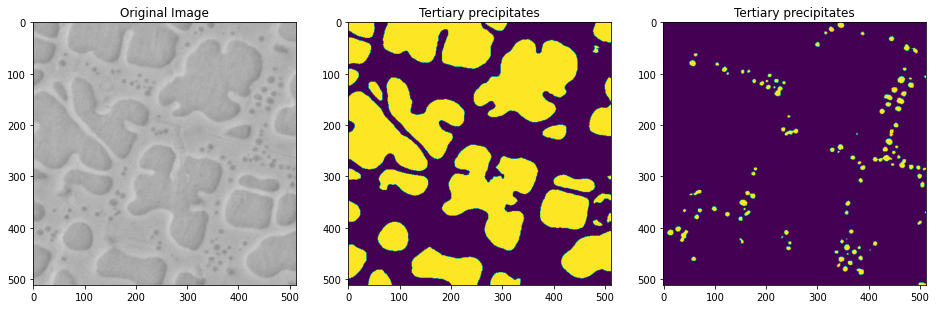

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16,16))
ax0.imshow(im)
ax0.set_title('Original Image')
ax1.imshow(pred[...,0])
ax1.set_title('Tertiary precipitates')
ax2.imshow(pred[...,1])
ax2.set_title('Tertiary precipitates');


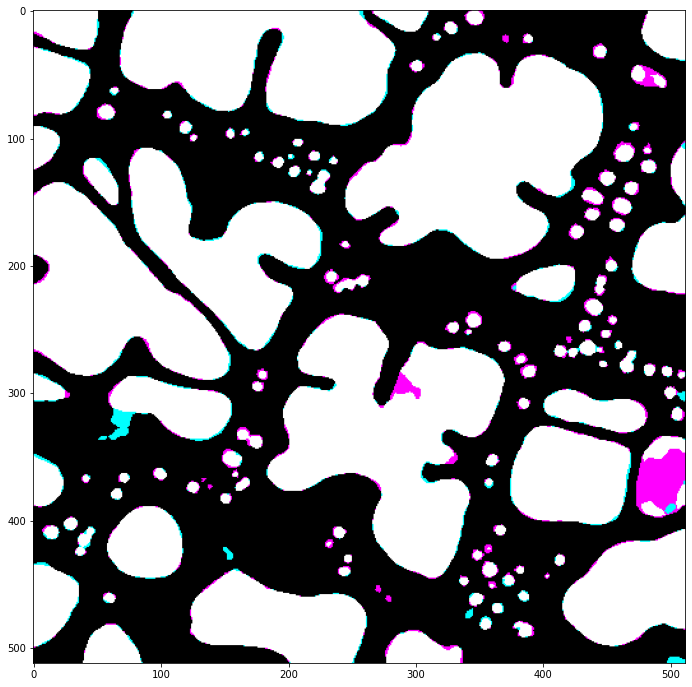

In [30]:
labels = [[0,0,255], [255,0,0]]
visual = pmm.segmentation_training.visualize_prediction_accuracy(pred, truth, labels)
plt.figure(figsize=(12,12))
plt.imshow(visual);